In [2]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname(os.getcwd()),"src"))
os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2,40).__str__()
import cv2
import numpy as np
from numpy import sin,cos,deg2rad,arcsin,arccos,rad2deg,pi,arctan2
from numpy import array,zeros,ones,dot,cross,sqrt,sum
from numpy.linalg import norm
import struct
from Point import *
from Structures import Quaternion,State
import mathutil as mu
import matplotlib.pyplot as plt

In [3]:
RADIUS = 1737400 # m
U_PIXELS = 92160
V_PIXELS = 46080
f = None # Binary file location

In [4]:
def open_dem(filename):
	"""
		Reads in the TIF DEM file, converts to bin for easy parsing,
		without having to keep the whole thing in memory. Defines 
		width and height of the sphere in pixels.
	"""
	global f
	bin_name = filename.replace(".tif",".bin")
	if not os.path.exists(bin_name):
		img = cv2.imread(filename,2)
		height, width = img.shape
		f = open(bin_name,"wb+")
		for j in range(height):
			for i in range(width):
				f.write(struct.pack("h",img[j][i]))
		f.close()
		del img
	f = open(bin_name,"rb")
	return


def get_pixel(u,v):
	"""
		Gets the current pixel value from the binary file
	"""
	global f
	#print("Read Location: {}".format(2*(U_PIXELS*v+u)))
	f.seek(2*(U_PIXELS*v+u))
	return struct.unpack("h",f.read(2))[0]


def get_height(u,v):
	"""
		Gets the Moon height at the given pixel coords.
	"""
	global scale, nom_rad
	#print("Pixel value @ ({},{}) is : {}".format(u,v,get_pixel(u,v)))
	return 1*(nom_rad+0.5*get_pixel(u,v))


def getXYZ(ra,decl,u,v):
	"""
		Gets the XYZ coords of the Moon Surface at the given
		RA/DECL and corresponding pixel coords.
	"""
	ra = deg2rad(ra)
	decl = deg2rad(decl)
	radius = get_height(u,v)
	x = radius*cos(decl)*cos(ra)
	y = radius*cos(decl)*sin(ra)
	z = radius*sin(decl)
	return x,y,z


def getXYZ_redux(u,v):
	"""
		Gets XYZ from u,v
	"""
	ra = 2*pi*((u+.5)/U_PIXELS) - pi
	decl = -pi*((v+.5)/V_PIXELS) + pi/2
	if 0 <= u < U_PIXELS and 0 <= v < V_PIXELS:
		radius = get_height(u,v)
		return array([radius*cos(decl)*cos(ra),
									radius*cos(decl)*sin(ra),
									radius*sin(decl)])
	else:
		return zeros(shape=(3,))


def writebinary(f,data,format):
	"""
		Write data to binary file. Assumes open file f.
	"""
	f.write(struct.pack(format,data))
	return


def prep_write_files(verts_file,faces_file,colors_file):
	"""
		Open binary files for writing
	"""
	global verts_f,colors_f,faces_f
	if os.path.exists(verts_file):
		os.remove(verts_file)
	if os.path.exists(faces_file):
		os.remove(faces_file)
	if os.path.exists(colors_file):
		os.remove(colors_file)
	verts_f = open(verts_file,"wb+")
	faces_f = open(faces_file,"wb+")
	colors_f = open(colors_file,"wb+")
	return


def add_vertex(xyz):
	global verts
	for i in range(3):
			writebinary(verts_f,xyz[i],"f")
	return


def add_face(ids):
	global faces
	for i in range(3):
		writebinary(faces_f,ids[i],"Q")
	return


def add_color(loc):
	global colors
	for i in range(2):
		writebinary(colors_f,loc[i],"f")
	return


def get_pos_los(ra,decl,alt):
	ra = deg2rad(ra)
	decl = deg2rad(decl)
	pos = array([alt*cos(ra)*cos(decl),
							 alt*sin(ra)*cos(decl),
							 alt*sin(decl)])
	los = -pos/np.linalg.norm(pos)
	return pos, los


def get_intersection(pos,los,r):
	nabla = dot(los,pos)**2-(np.linalg.norm(pos)**2-r**2)
	if nabla < 0:
		# No solutions
		return None
	d = -dot(los,pos)+sqrt(nabla)
	return pos + los*d


def uv2los(u,v,fov,pixels):
	angles_per_pixel = fov/pixels
	los = array([-(u-(pixels[0]/2)+.5)*angles_per_pixel[0],
							 -(v-(pixels[1]/2)+.5)*angles_per_pixel[1],
							 1])
	los = los/np.linalg.norm(los)
	return los


def rot_about(a,b,theta):
	a_par_b = (dot(a,b)/dot(b,b))*b
	a_perp_b = a - a_par_b
	w = cross(b,a_perp_b)
	x1 = cos(theta)/np.linalg.norm(a_perp_b)
	x2 = sin(theta)/np.linalg.norm(w)
	a_perp_btheta = np.linalg.norm(a_perp_b)*(x1*a_perp_b+x2*w)
	return array(a_perp_btheta + a_par_b)


def ijk2moonuv(ijk):
	r = np.linalg.norm(ijk)
	decl = arcsin(max(-1,min(ijk[2]/r,1)))
	if abs(cos(decl)) < 1e-10:
		ra = 0
	else:
		ra = arctan2(ijk[1]/(r*cos(decl)),ijk[0]/(r*cos(decl)))
	u = ((U_PIXELS-1)/2)+(U_PIXELS/360.*rad2deg(ra))
	v = ((V_PIXELS-1)/2)-(V_PIXELS/180.*rad2deg(decl))
	return u,v


def find_point(ijk):
	u,v = ijk2moonuv(ijk)
	u = int(round(u,0))
	v = int(round(v,0))
	#print("UV = {},{}".format(u,v))
	return getXYZ_redux(u,v)


def uv2vertid(u,v,u_size):
	return v*u_size+u

In [5]:
FOV = array([deg2rad(20),deg2rad(16)])
PIXELS = array([2592,2048])
N_SUBPIXELS = 1
OFFSET_PIX = array([20,20])

dem_file = "../images/big_dem.tif"
verts_file = "verts_redux.bin"
colors_file = "colors_redux.bin"
faces_file = "faces_redux.bin"
dem_file_c = "../images/big_dem.bin"

print("Loading DEM")
open_dem(dem_file)
print("Finished Loading DEM")


Loading DEM
Finished Loading DEM


In [6]:
### The Grassy Knoll Method

# Let's Build a Moon
ra_sections = 360
decl_sections = 180
ra = np.linspace(0,2*np.pi,ra_sections,endpoint=False)
ras = np.tile(ra,decl_sections).reshape(decl_sections,ra_sections)
#print(ras)
decl = np.linspace(-np.pi/2,np.pi/2,decl_sections)
decls = np.repeat(decl,ra_sections).reshape(decl_sections,ra_sections)
latlons = array([ras,decls]).transpose((2,1,0))
#print(decls)
xyzs = array([RADIUS*cos(decls)*cos(ras),RADIUS*cos(decls)*sin(ras),RADIUS*sin(decls)]).transpose((2,1,0))
max_fov = deg2rad(20)
fov_bounds = cos(max_fov/2)
print("FOV Bounds: {:.4f}".format(fov_bounds))

FOV Bounds: 0.9848


0.5 [ 0.5 -0.5  0.5]
0.5 [ 0.5  0.5 -0.5]
[-1.  0.  0.]
NADIR Angle = 45.00000000000001


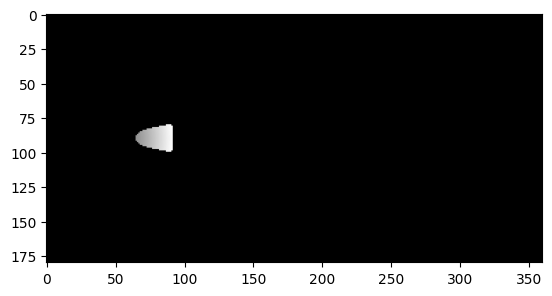

In [19]:
position = array([RADIUS,RADIUS,0])
quatWorldtoCam = Quaternion()
quatWorldtoCam.fromDCM(array([[0,0,1],
															[-1,0,0],
															[0,-1,0]]))
sc_quat = Quaternion(0,[0,0,1])
#sc_quat = Quaternion(0.707,[0,0,-0.707])
#sc_quat = Quaternion(1,[0,0,0])
quat = Quaternion()
dcm = sc_quat.toDCM().T@quatWorldtoCam.toDCM()
#print(sc_quat.toDCM())
#print(quatWorldtoCam.toDCM())
#print(dcm)
quat.fromDCM(dcm)
state = State(position,quat)
DCM = state.attitude.toDCM()
los = DCM@array([0,0,1])
print(los)
pos = state.position
TOL = 100000
OFFNADIR_THRESH = deg2rad(10)
unity_pos = pos/norm(pos)
offnadir = arccos(dot(unity_pos,-los))
print("NADIR Angle = {}".format(rad2deg(offnadir)))
if offnadir < OFFNADIR_THRESH:
	pass
#nabla = dot(los,pos)**2-(np.linalg.norm(pos)**2-r**2)
diff = xyzs-pos
moon_los = diff/norm(diff,axis=2).reshape(ra_sections,decl_sections,1)
#print(-moon_los)
nabla = dot(-moon_los,pos)**2-(norm(pos)**2-RADIUS**2)
min_dist = abs(-dot(-moon_los,pos)+sqrt(nabla))
#print(nabla)
#print(min_dist)
angles = np.where(min_dist+TOL>=norm(diff,axis=2),np.dot(moon_los,los),-1)
blob_target = np.where(angles>fov_bounds,norm(diff,axis=2),-1)
#print(angles)
plt.imshow(blob_target.T,cmap="gray")

In [20]:
# Finding the center of the blob
blob_xyzs = np.where(blob_target.reshape(360,180,1)>-1,xyzs,array([0,0,0]))
blob_mask = np.array(np.where(norm(blob_xyzs,axis=2)>0))
#print(blob_mask.shape)
#print(blob_xyzs)
#plt.imshow(norm(blob_xyzs,axis=2).T,cmap="gray")
#plt.imshow(blob_mask.T,cmap="gray")
pts_xyzs = blob_xyzs[blob_mask[0,:],blob_mask[1,:],:]
#print(pts_xyzs)
if len(pts_xyzs) == 0:
	print("No dice")
else:
	ctr_xyz = np.average(pts_xyzs,axis=0)
	ctr_los = ctr_xyz/norm(ctr_xyz)
	decl = arcsin(ctr_los[2])
	if decl > np.pi/2:
		decl -= np.pi
	ra = arccos(ctr_los[0]/cos(decl))
	print(ctr_los)
	print(rad2deg(ra),rad2deg(decl))

[ 1.71642041e-01  9.85159383e-01 -9.79098831e-17]
80.11669544706328 -5.609823071935808e-15


In [21]:
def get_coverage(pos,los,moon_xyzs,fov):
	shape = array(moon_xyzs.shape)
	shape[2] = 1
	diff = moon_xyzs-pos
	fov_bounds = cos(fov/2)
	max_dist = sqrt(norm(pos)**2+RADIUS**2)
	moon_los = diff/norm(diff,axis=2).reshape(shape)
	angles = np.where(norm(diff,axis=2)<=max_dist,np.dot(moon_los,los),-1)
	blob = np.where(angles>fov_bounds,norm(diff,axis=2),-1)
	plt.figure()
	plt.imshow(blob.T,cmap="gray")
	return blob

398
386
76
0
[[-9.85159383e-01 -1.38777878e-17 -1.71642041e-01]
 [ 1.71642041e-01 -5.55111512e-17 -9.85159383e-01]
 [ 0.00000000e+00 -1.00000000e+00 -1.66533454e-16]]
0.060911035859308196 [ 0.06091104  0.70447842 -0.70447842]
[ 2.77555756e-17 -4.08405397e-17  1.00000000e+00]
[-1.71642041e-01 -9.85159383e-01 -1.66533454e-16]
[-1.71642041e-01 -9.85159383e-01  9.79098831e-17]


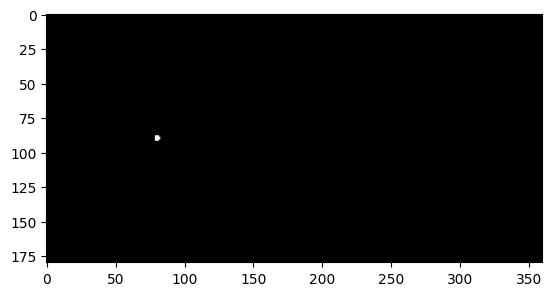

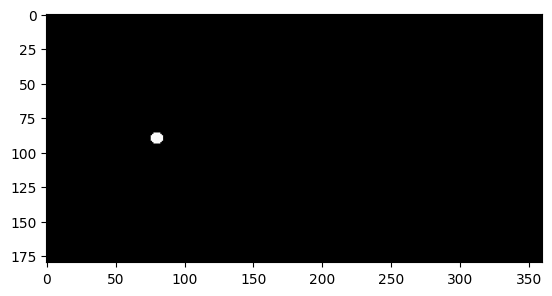

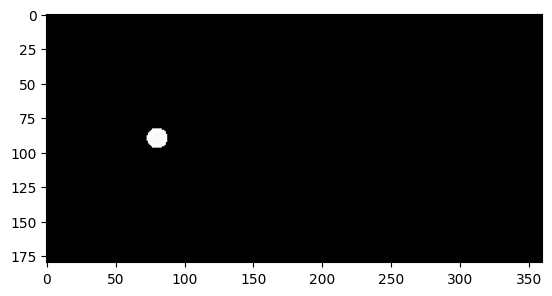

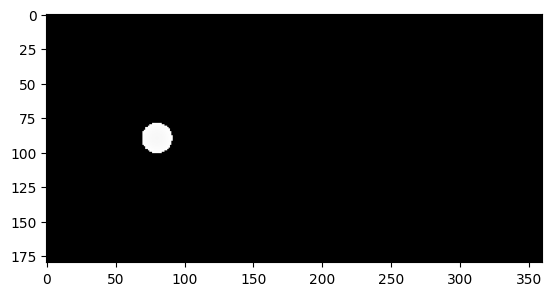

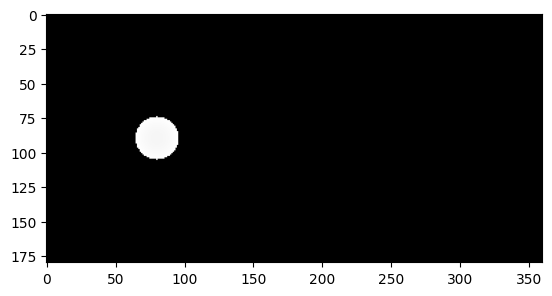

In [22]:
# Finding the furthest extremities
pos2 = ctr_los*RADIUS*1.2
los2 = -ctr_los
blob = get_coverage(pos2,los2,xyzs,max_fov)
cont = len(np.where(blob_target>blob)[0])
while cont > 0:
	pos2*=1.2
	blob = get_coverage(pos2,los2,xyzs,max_fov)
	cont = len(np.where(blob_target>blob)[0])
	print(cont)
global_z = los2
global_x = array([-sin(ra),cos(ra),0])
global_y = rot_about(global_z,global_x,pi/2)
local_z = array([0,0,1])
local_x = array([1,0,0])
local_y = array([0,-1,0])
dcm = mu.wahbas_problem(array([global_z,global_x,global_y]),
											array([local_z,local_x,local_y]))
print(dcm)
quat = Quaternion()
quat.fromDCM(dcm)
#print(quat)
print(dcm.T@global_z)
print(dcm@array([0,0,1]))
print(global_z)